# Snowflake ML using Warehouse Compute

# Create Session

In [1]:
from config import get_snowpark_session

session = get_snowpark_session()

c:\Users\Andrew\Code\data_platform\.venv\lib\site-packages\snowflake\snowpark\_internal\packaging_utils.py:18: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources


session_id: 944609337499738
version: 1.36.0
database: "_DEV_ANALYTICS"
schema: "ASTAUS"
user: "astaus"


# Load Data

In [2]:
from snowflake.snowpark import functions as F

In [3]:
df = (
    session.table(["_dev_analytics", "transaction_db__astaus", "transactions"])
    .select(
        "sales_channel",
        F.col("transaction_revenue").cast("double").alias("transaction_revenue"),
        F.col("transaction_margin").cast("double").alias("transaction_margin"),
    )
)

# Exploratory Data Analysis

In [4]:
import seaborn as sns
from matplotlib import pyplot as plt
from snowflake.ml.modeling.metrics.correlation import correlation


In [5]:
df.show()

------------------------------------------------------------------
|"SALES_CHANNEL"  |"TRANSACTION_REVENUE"  |"TRANSACTION_MARGIN"  |
------------------------------------------------------------------
|web              |500.0                  |50.0                  |
|web              |500.0                  |50.0                  |
|web              |500.0                  |50.0                  |
|web              |500.0                  |50.0                  |
|store            |500.0                  |50.0                  |
|store            |500.0                  |50.0                  |
|store            |500.0                  |50.0                  |
|store            |500.0                  |50.0                  |
------------------------------------------------------------------



In [7]:
session.use_schema("transaction_db__astaus")

In [25]:
df2 = session.create_dataframe([[0.1, 0.5], [0.2, 0.6], [0.3, 0.7]], schema=["a", "b"])
df2.stat.corr("a", "b")

0.9999999999999991

In [26]:
df2.stat.cov("a", "b")

0.010000000000000037

In [32]:
df.dtypes

[('SALES_CHANNEL', 'string(25)'),
 ('TRANSACTION_REVENUE', 'double'),
 ('TRANSACTION_MARGIN', 'double')]

In [31]:
df2.dtypes

[('A', 'double'), ('B', 'double')]

In [33]:
df.stat.corr("TRANSACTION_REVENUE", "TRANSACTION_MARGIN")

In [35]:
corr = correlation(df=df, columns=["TRANSACTION_REVENUE", "TRANSACTION_MARGIN"])
corr

,TRANSACTION_REVENUE,TRANSACTION_MARGIN
TRANSACTION_REVENUE,NaN,NaN
TRANSACTION_MARGIN,NaN,NaN


In [36]:
correlation(df=df2, columns=["a", "b"])

,a,b
a,1.0,1.0
b,1.0,1.0


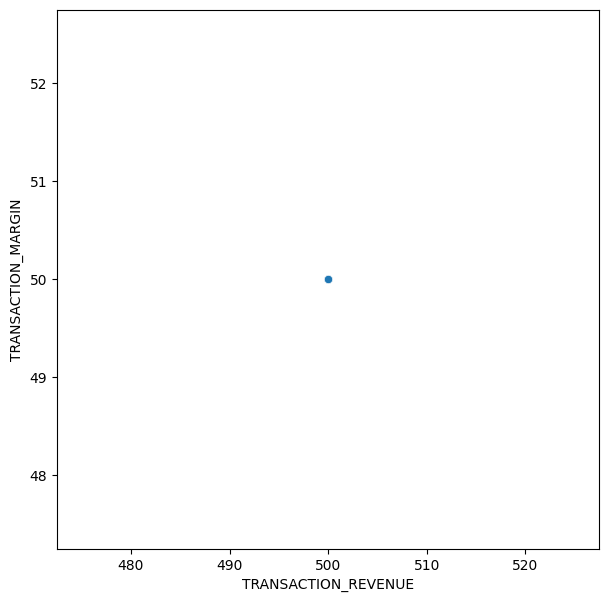

In [ ]:
plt.figure(figsize=(7, 7))
heatmap = sns.scatterplot(
    df.toPandas(),
    x="TRANSACTION_REVENUE",
    y="TRANSACTION_MARGIN")
plt.show()

# Create Dataset
This will create an imutable, versioned dataset that can be used for reproducable
training results

In [13]:
from snowflake.ml import dataset

In [14]:
ds = dataset.create_from_dataframe(
    session=session,
    name="margin_prediction_training",
    version="v1",
    input_dataframe=df
)

# Train Model
https://docs.snowflake.com/en/developer-guide/snowpark-ml/reference/latest/modeling

In [ ]:
from snowflake.ml.modeling.pipeline.pipeline import Pipeline
from snowflake.ml.modeling.preprocessing.one_hot_encoder import OneHotEncoder
from snowflake.ml.modeling.preprocessing.standard_scaler import StandardScaler
from snowflake.ml.modeling.xgboost.xgb_regressor import XGBRegressor

In [22]:
train = ds.read.to_snowpark_dataframe()

pipe = Pipeline(steps=[
    ("onehot", OneHotEncoder(
        categories="auto",
        input_cols=["SALES_CHANNEL"],
        output_cols=["SALES_CHANNEL"],
        drop_input_cols=True
    )),
    ("scale", StandardScaler(
        input_cols=["TRANSACTION_REVENUE"],
        output_cols=["TRANSACTION_REVENUE"]
    )),
    ("reg", XGBRegressor(
        label_cols=["TRANSACTION_MARGIN"],
        output_cols=["TRANSACTION_MARGIN_PRED"],
        drop_input_cols=True
    ))
])

pipe = pipe.fit(train)

c:\Users\Andrew\Code\data_platform\.venv\lib\site-packages\snowflake\ml\modeling\preprocessing\one_hot_encoder.py:519: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: dict(zip(x[_CATEGORY], x[_COUNT])))
Package 'snowflake-telemetry-python' is not installed in the local environment. Your UDF might not work when the package is installed on the server but not on your local environment.


In [ ]:
preds = pipe.predict(df.drop("TRANSACTION_MARGIN"))

-----------------------------
|"TRANSACTION_MARGIN_PRED"  |
-----------------------------
|50.0                       |
|50.0                       |
|50.0                       |
|50.0                       |
|50.0                       |
|50.0                       |
|50.0                       |
|50.0                       |
-----------------------------



In [24]:
pipe.score(df)

1.0

# Register Model

In [25]:
import pathlib

from snowflake.ml.model.task import Task
from snowflake.ml.registry import Registry

pathlib.PosixPath = pathlib.PurePosixPath

In [26]:
registry = Registry(
    session=session,
    database_name="_dev_analytics",
    schema_name="transaction_db__astaus"
)

In [27]:
model_ref = registry.log_model(
    pipe,
    comment="",
    metrics={},
    task=Task.TABULAR_REGRESSION,
    model_name="sfml_margin_prediction",
    version_name="v1",
    sample_input_data=df.drop("transaction_margin"),
    options={
        "relax_version":True
    }
)

Logging model: creating model manifest...:  33%|███▎      | 2/6 [00:02<00:04,  1.11s/it]  

c:\Users\Andrew\Code\data_platform\.venv\lib\site-packages\snowflake\ml\model\_packager\model_packager.py:89: UserWarning: Providing model signature for Snowpark ML Modeling model is not required. Model signature will automatically be inferred during fitting. 
  handler.save_model(
c:\Users\Andrew\Code\data_platform\.venv\lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but OneHotEncoder was fitted without feature names
  warnings.warn(
c:\Users\Andrew\Code\data_platform\.venv\lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


Model logged successfully.: 100%|██████████| 6/6 [01:32<00:00, 15.38s/it]                          


# Inference

In [28]:
session.sql(""" --begin-sql

    with ml as model _dev_analytics.transaction_db__astaus.sfml_margin_prediction

    select
        transaction_id,
        product_id,
        sales_channel,
        transaction_revenue,
            
        ml!predict(
            sales_channel,
            transaction_revenue
        ):TRANSACTION_MARGIN_PRED::number(16,2) transaction_margin_pred

    from _dev_analytics.transaction_db__astaus.transactions

""").show()

---------------------------------------------------------------------------------------------------------
|"TRANSACTION_ID"  |"PRODUCT_ID"  |"SALES_CHANNEL"  |"TRANSACTION_REVENUE"  |"TRANSACTION_MARGIN_PRED"  |
---------------------------------------------------------------------------------------------------------
|88888             |1556434       |store            |500.00                 |50.00                      |
|77777             |1556434       |store            |500.00                 |50.00                      |
|78654             |1556434       |store            |500.00                 |50.00                      |
|12345             |1556434       |web              |500.00                 |50.00                      |
|12345             |1556434       |web              |500.00                 |50.00                      |
|56789             |1556434       |web              |500.00                 |50.00                      |
|56789             |1556434       |web        

In [44]:
session.sql(""" --begin-sql

    create or replace table
            _dev_analytics.transaction_db__astaus.margin_prediction_baseline
    as select * from _dev_analytics.transaction_db__astaus.transactions
    ;

""").collect()[0][0]

'Table MARGIN_PREDICTION_BASELINE successfully created.'

In [45]:
session.sql(""" --begin-sql

    create or replace model monitor margin_prediction_monitor with
        model=_dev_analytics.transaction_db__astaus.sfml_margin_prediction
        version='V1'
        function='predict'
        source=_dev_analytics.transaction_db__astaus.transactions
        warehouse=compute_wh
        id_columns=(transaction_id, product_id)
        refresh_interval='1 day'
        aggregation_window='1 day'
        timestamp_column=transacted_at
        baseline=_dev_analytics.transaction_db__astaus.margin_prediction_baseline
        prediction_score_columns=(transaction_margin)
    ;

""")